In [119]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import nengo
import nengo_dl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [73]:
churn_data = pd.read_csv('./churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [74]:

# Extract features and labels
X = churn_data.drop(labels=['CustomerId', 'Surname', 'RowNumber', 'Exited'], axis=1)
Y = churn_data['Exited']

X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [75]:
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [76]:
# Label categorical data
lb = LabelEncoder()
X['Geography'] = lb.fit_transform(X['Geography'])
lb = LabelEncoder()
X['Gender'] = lb.fit_transform(X['Gender'])

X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


In [77]:
X = pd.get_dummies(X, drop_first=True, columns=['Geography'])

X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_1,Geography_2
0,619,0,42,2,0.00,1,1,1,101348.88,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,False,True


In [78]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio, stratify=Y)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio),  stratify=Y_test)

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [80]:
inp = tf.keras.Input(shape=(X_train.shape[1]))
dense = tf.keras.layers.Dense(128, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    batch_size=10,
    epochs=10,
    validation_data=(X_val, Y_val),
    verbose=1
)

Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 0.4314 - accuracy: 0.8147 - val_loss: 0.3774 - val_accuracy: 0.8460
Epoch 2/10
750/750 [==============================] - 1s 856us/step - loss: 0.3734 - accuracy: 0.8484 - val_loss: 0.3486 - val_accuracy: 0.8600
Epoch 3/10
750/750 [==============================] - 1s 857us/step - loss: 0.3578 - accuracy: 0.8544 - val_loss: 0.3353 - val_accuracy: 0.8593
Epoch 4/10
750/750 [==============================] - 1s 850us/step - loss: 0.3526 - accuracy: 0.8556 - val_loss: 0.3322 - val_accuracy: 0.8673
Epoch 5/10
750/750 [==============================] - 1s 851us/step - loss: 0.3489 - accuracy: 0.8556 - val_loss: 0.3325 - val_accuracy: 0.8573
Epoch 6/10
750/750 [==============================] - 1s 873us/step - loss: 0.3462 - accuracy: 0.8567 - val_loss: 0.3274 - val_accuracy: 0.8693
Epoch 7/10
750/750 [==============================] - 1s 861us/step - loss: 0.3445 - accuracy: 0.8591 - val_loss: 0.3255 - val_accuracy: 0

In [81]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

32/32 [==============================] - 0s 645us/step - loss: 0.3304 - accuracy: 0.8620
test loss, test acc: [0.33037862181663513, 0.8619999885559082]


In [123]:
# Accuracy score of non spiking network
threshold = 0.5

Y_pred_ann = model.predict(X_test)
Y_pred_ann = np.where(Y_pred_ann > threshold, 1,0)

ann_accuracy = accuracy_score(Y_test, Y_pred_ann)
ann_accuracy

32/32 [==============================] - 0s 694us/step


0.862

In [82]:
def add_time_dimension(arr):
    return np.reshape(arr, (arr.shape[0], 1, -1))

X_train_t = add_time_dimension(X_train)
Y_train_t = add_time_dimension(Y_train)
X_val_t = add_time_dimension(X_val)
Y_val_t = add_time_dimension(Y_val)
X_test_t = add_time_dimension(X_test)
Y_test_t = add_time_dimension(Y_test)

In [83]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    sim.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    converted_inp = converter.inputs[model.input]
    converted_dense = converter.outputs[model.output]

    sim.fit(
        {converted_inp: X_train_t},
        {converted_dense: Y_train_t},
        validation_data=(
            {converted_inp: X_train_t},
            {converted_dense: Y_train_t}
        ),
        epochs=10
    )

    sim.save_params("./keras_to_snn_params")

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Cons

c:\Users\colto\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Constructing graph: build stage finished in 0:00:00
| #                       Constructing graph                          | 0:00:00
Construction finished in 0:00:00
Epoch 1/10
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00


c:\Users\colto\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\simulator.py:1892: UserWarning: Number of elements in input data (7500) is not evenly divisible by Simulator.minibatch_size (200); input data will be truncated.
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
29/37 [======================>.......] - ETA: 0s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8609|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
37/37 [==============================] - 1s 14ms/step - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8641 - val_loss: 0.3312 - val_probe_loss: 0.3312 - val_probe_accuracy: 0.8651
Epoch 2

In [125]:

activation = activation=nengo.RectifiedLinear()
params_file = "keras_to_snn_params"
n_steps = 10
scale_firing_rates = 1
synapse = None
n_test = 1000

# convert the keras model to a nengo network
nengo_converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: activation},
    scale_firing_rates=scale_firing_rates,
    synapse=synapse,
)

# get input/output objects
nengo_input = nengo_converter.inputs[model.input]
nengo_output = nengo_converter.outputs[model.output]

# add a probe to the first dense layer to record activity.
# we'll only record from a subset of neurons, to save memory.
sample_neurons = np.linspace(
    0,
    np.prod(dense.shape[1:]),
    1000,
    endpoint=False,
    dtype=np.int32,
)
with nengo_converter.net:
    dense_probe = nengo.Probe(nengo_converter.layers[dense][sample_neurons])

# repeat inputs for some number of timesteps
tiled_test_images = np.tile(X_test_t[:n_test], (1, n_steps, 1))

# set some options to speed up simulation
with nengo_converter.net:
    nengo_dl.configure_settings(stateful=False)

# build network, load in trained weights, run inference on test images
with nengo_dl.Simulator(
    nengo_converter.net, minibatch_size=10, progress_bar=False
) as nengo_sim:
    nengo_sim.load_params(params_file)
    data = nengo_sim.predict({nengo_input: tiled_test_images})



c:\Users\colto\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\converter.py:563: UserWarning: Firing rate scaling being applied to activation type that does not support amplitude (Sigmoid); this will change the output
  warnings.warn(
c:\Users\colto\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\converter.py:140: UserWarning: swap_activations contained {<function relu at 0x00000217DAE71900>}, but there were no layers in the model with that activation type
  warnings.warn(
c:\Users\colto\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


100/100 [==============================] - 0s 3ms/step


In [126]:
# Compare accuracies of snn to ann
Y_pred_snn = np.where(data[nengo_output][:, -1] > threshold, 1, 0)
snn_accuracy = accuracy_score(Y_test, Y_pred_snn)
print(f"ANN accuracy: {100 * ann_accuracy:.2f}%")
print(f"SNN accuracy: {100 * snn_accuracy:.2f}%")

ANN accuracy: 86.20%
SNN accuracy: 86.50%


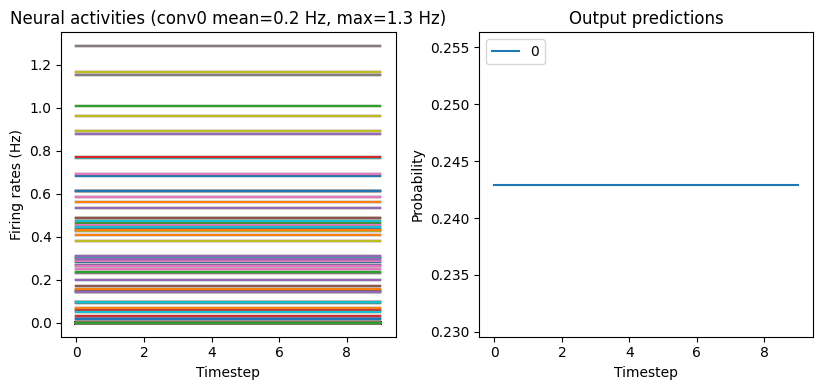

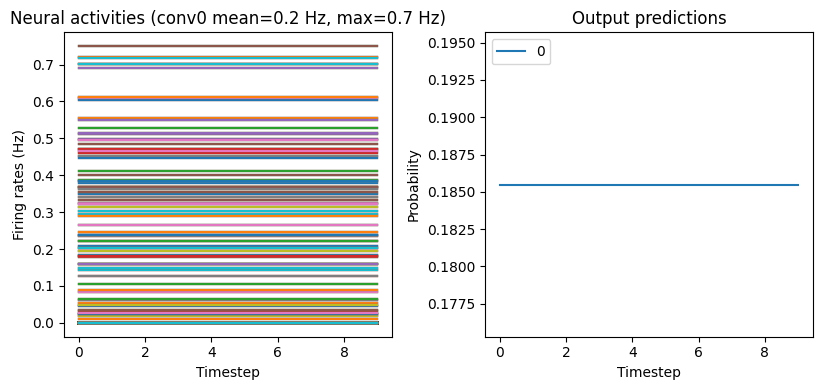

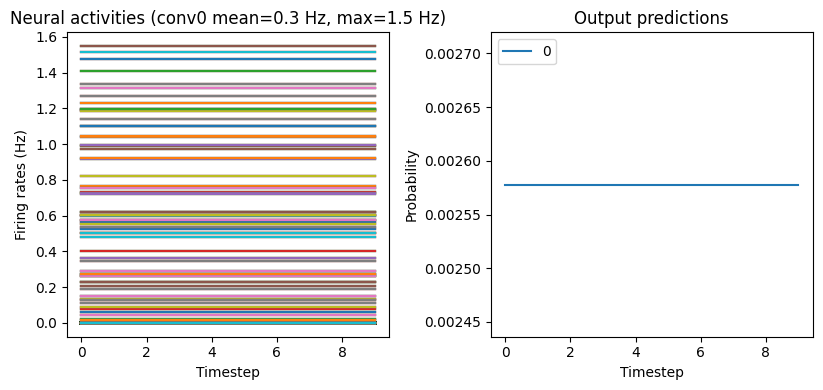

In [87]:
# plot the results
for ii in range(3):
    plt.figure(figsize=(12, 4))


    plt.subplot(1, 3, 2)
    scaled_data = data[dense_probe][ii] * scale_firing_rates
    if isinstance(activation, nengo.SpikingRectifiedLinear):
        scaled_data *= 0.001
        rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
        plt.ylabel("Number of spikes")
    else:
        rates = scaled_data
        plt.ylabel("Firing rates (Hz)")
    plt.xlabel("Timestep")
    plt.title(
        f"Neural activities (dense mean={rates.mean():.1f} Hz, "
        f"max={rates.max():.1f} Hz)"
    )
    plt.plot(scaled_data)

    plt.subplot(1, 3, 3)
    plt.title("Output predictions")
    plt.plot(data[nengo_output][ii])
    plt.legend([str(j) for j in range(10)], loc="upper left")
    plt.xlabel("Timestep")
    plt.ylabel("Probability")

    plt.tight_layout()